# Entity extraction
Partendo da collection raw, estraggo alcuni tipi di entità (nomi, aggettivi, ecc) e metto in rumors_entity, che ha stessi elementi in aggiunta un campo "entities"

In [140]:
import pymongo
client=pymongo.MongoClient()#senza parametri si connette a localhost.

client.list_database_names()

db=client['inforet']#prendo il db, se non c'è lo crea

col = db['rumors_raw']

tweets = []
for record in col.find():
    tweets.append(record)

### Estrazione entità e tagging con CMU Tagger

In [141]:
import nbimporter
from TweetParser.TweetParser import TweetParser #http://www.cs.cmu.edu/~ark/TweetNLP/

parser = TweetParser() # oppure parser = TweetParser(tags_to_keep) #tags_to_keep = [ 'N','^','S','Z','A','#','$'] #print parser.tags_to_keep
#tagged_entities = parser.tokenize_tweets_from_file("TweetParser/examples/example_tweets.txt")
entities = parser.tokenize_tweets(tweets)
print "Parsed: " + str(len(entities))

Parsed: 8560


### Aggiunta al db

In [143]:
for i in range(len(tweets)):
    tweets[i]['entities']= entities[i]

In [144]:
client=pymongo.MongoClient()
db=client['inforet']
db["rumors_entity_cmu"].drop()
col = db["rumors_entity_cmu"]
col.insert_many(tweets)

### Filtraggio per tipo

In [145]:
list_of_types = [ 'N','^','S','Z','A','#','$']

def keep_only_entities_of_type(entities, list_of_types):
    for index, l in enumerate(entities):
        filtered_list = [entity_tag for entity_tag in l if entity_tag[1] in list_of_types]
        entities[index] = filtered_list
    return entities

### Rimozione stopwords

In [146]:
from nltk.corpus import stopwords

def remove_stopwords(entities, list_of_stopwords=[]):
    
    if not list_of_stopwords:
        list_of_stopwords = set(stopwords.words('english'))
    
    for index, l in enumerate(entities):
        filtered_list = [entity_tag for entity_tag in l if entity_tag[0].lower() not in list_of_stopwords]
        entities[index] = filtered_list
    return entities

#### Remove confidence

In [147]:
def remove_confidence(entities):
    for index, l in enumerate(entities):
        filtered_list = [ (entity_tag[0],entity_tag[1]) for entity_tag in l]
        entities[index] = filtered_list
    return entities

#### lowercase

In [148]:
def entities_to_lower(entities):
    for list_index, list_entities_in_tweet in enumerate(entities):
        for index_entity, entity_tag in enumerate(list_entities_in_tweet):
            entities[list_index][index_entity] = (entity_tag[0].lower(),entity_tag[1],entity_tag[2])
    return entities

In [149]:
#entities_to_lower(entities)
#print len(set([tag[0] for e in entities for tag in e ]))

### Pre-processing pipeline

#### Tags to keep

tags_to_keep= [ 'N','^','Z','A','#','$','S'] 

sono quelle più legate alla parte nominale
 
dubbie V verbi U url R avverbi. 

Decise:  @ at E esclamazioni G garbage/foreign words ! interiezioni

In [150]:
#UNIQUEEE
u= dict()
for t in parser.tags_meaning.keys():
    n = len(set([tag[0] for e in entities for tag in e if tag[1] == t]))
    u[t]=n
print u

{'!': 276, '#': 598, '$': 277, '&': 24, ',': 119, 'A': 1204, '@': 1895, 'E': 40, 'D': 98, 'G': 460, 'M': 0, 'L': 107, 'O': 105, 'N': 4015, 'P': 217, 'S': 20, 'R': 408, 'U': 3183, 'T': 14, 'V': 2371, 'Y': 0, 'X': 7, 'Z': 108, '^': 2754, '~': 35}


In [151]:
from prettytable import PrettyTable
from collections import Counter

c = Counter([tag[1] for e in entities for tag in e ]).most_common()

x = PrettyTable()

x.field_names = ["Type","Total","Unique","Rate","Meaning"]

meanings = parser.tags_meaning

#UNIQUEEE
u= dict()
for t in parser.tags_meaning.keys():
    n = len(set([tag[0] for e in entities for tag in e if tag[1] == t]))
    u[t]=n
#print u

from nltk.corpus import stopwords
list_of_stopwords = set(stopwords.words('english'))

stopw= dict()
for t in parser.tags_meaning.keys():
    n = len(set([tag[0] for e in entities for tag in e if tag[1] == t and tag[0] in list_of_stopwords ]))
    stopw[t]=n

for v in c:
    v = list(v)
    #print meanings[v[0]]
    v.append(u[v[0]])
    v.append(float(u[v[0]])*100/v[1])
    #v.append(stopw[v[0]])
    v.append(meanings[v[0]])
    
    #print v
    x.add_row(v)



x.align["Meaning"] = "l"
x.align["Total"] = "r"
x.align["Unique"] = "r"
x.align["Rate"] = "r"
#x.align["Stopwords"] = "r"
print(x)

+------+-------+--------+----------------+-----------------------------------------------------------------------------------+
| Type | Total | Unique |           Rate | Meaning                                                                           |
+------+-------+--------+----------------+-----------------------------------------------------------------------------------+
|  N   | 26850 |   4015 |  14.9534450652 | common noun                                                                       |
|  ^   | 24122 |   2754 |  11.4169637675 | proper noun                                                                       |
|  V   | 21279 |   2371 |  11.1424409042 | verb incl. copula, auxiliaries                                                    |
|  ,   | 20951 |    119 |  0.56799198129 | punctuation                                                                       |
|  P   | 15524 |    217 |  1.39783560938 | pre- or postposition, or subordinating conjunction                  

In [152]:
tags_to_keep= [ 'N','^','S','Z','A','#','$']

#### Pipeline Execution

In [153]:
import pymongo
import nbimporter
from TweetParser.TweetParser import TweetParser #http://www.cs.cmu.edu/~ark/TweetNLP/

client=pymongo.MongoClient()#senza parametri si connette a localhost.

db=client['inforet']#prendo il db, se non c'è lo crea

col = db['rumors_entity_cmu']

### RETRIEVAL
p = []
p.append({'$match':{'languages':'en'}})

selection = {}
#selection = {'rumor': { '$in': ['michelle','airfrance','palin']}}
print selection
p.append({'$match': selection})

tweets = []
entities = []
for record in col.aggregate(p): # col.find(selection):
    tweets.append(record)
    entities.append(record['entities'])

print "Retrieved " + str(len(entities)) + " tweets"

remove_stopwords(entities)
keep_only_entities_of_type(entities,[ 'N','^','S','Z','A','#','$'])

### INSERT IN DB AS NEW COLLECTION
for i in range(len(tweets)):
    tweets[i]['entities'] = entities[i]
db["rumors_entity_cmu_filtered"].drop()
col = db["rumors_entity_cmu_filtered"]
col.insert_many(tweets)

{}
Retrieved 7777 tweets


### Tracker

In [2]:
import nbimporter
from Tracker import Tracker

## Cluster

In [3]:
import nbimporter
from Tracker import Cluster

In [4]:
jd = Tracker('inforet','rumors_entity_cmu_filtered',decay_window=24,similarity_threshold= 0.3)

In [5]:
print jd.window_size
print jd.update_for_first_k
print jd.update_for_every_n
print jd.hashtag_boost
print jd.decay_window
#print jd.decay_factor_T
print jd.clear_under_percentile
#print jd.icfs
print jd.clusters

60
200
10
1.5
24
80
[]


In [ ]:
import datetime

a = datetime.datetime.now()
print "start ", a

jd.clusterize(use_decay=True)#True)
b = datetime.datetime.now()

print "end ", b
print "delta", b-a

In [7]:
print len(jd.clusters)
print len(jd.discarded)

929
0


In [8]:
cl = jd.clusters[2]
cl.M.shape

(9L, 1L)

# Analisi Risultati

In [9]:
cl_lens = [len(c.tweets) for c in jd.clusters]
import numpy as np
print np.mean(cl_lens)
print np.max(cl_lens)
print np.min(cl_lens)
print np.percentile(cl_lens,90)
print np.median(cl_lens)
#print np.var(cl_lens)

8.371367061356297
528
1
19.0
2.0


 ### Clusters size


In [10]:
degree_sample = cl_lens

In [11]:
# np.arange(min_t,max_t+1) #Perchè +1? perchè vengono generati valori fino a max_t, max t escluso
# +2 perchè altrimenti unisce gli ultimi due intervalli
count_people, bins_people = np.histogram(degree_sample,np.arange(np.min(degree_sample),np.max(degree_sample)+2))

pdf_people = count_people/float(len(degree_sample))
#print pdf_people
sum(pdf_people)

1.0000000000000007

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

Text(0,0.5,'PDF')

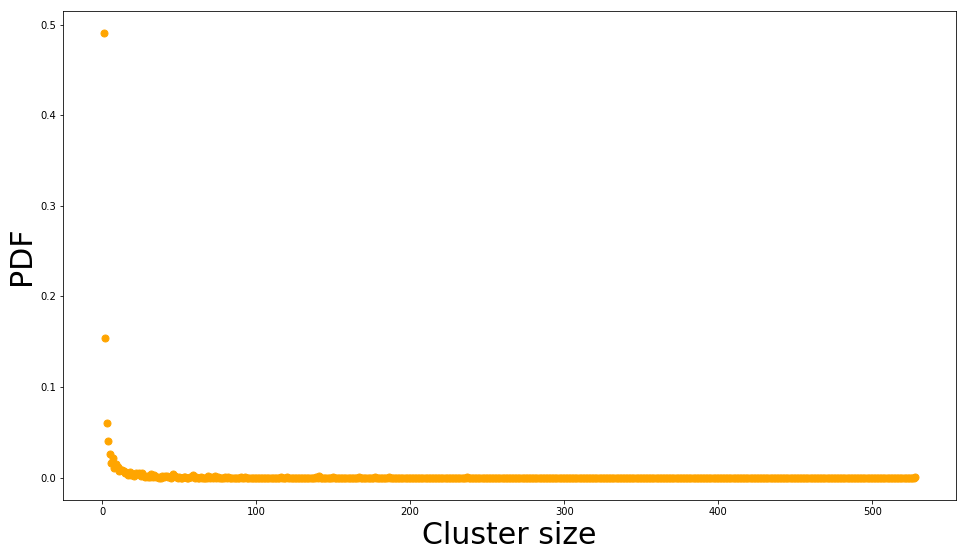

In [13]:
fig = plt.figure(figsize=(16,9)) #è la dimensione del grafico
assi = fig.gca()
assi.plot(bins_people[:-1],pdf_people,color='orange',marker='o',linestyle='None', ms = 7)
assi.set_xlabel('Cluster size',size=30)
assi.set_ylabel('PDF',size=30)
#fig.savefig('/Users/Cheick/Desktop/pdf_2k.png', dpi=300)

Text(0,0.5,'CDF')

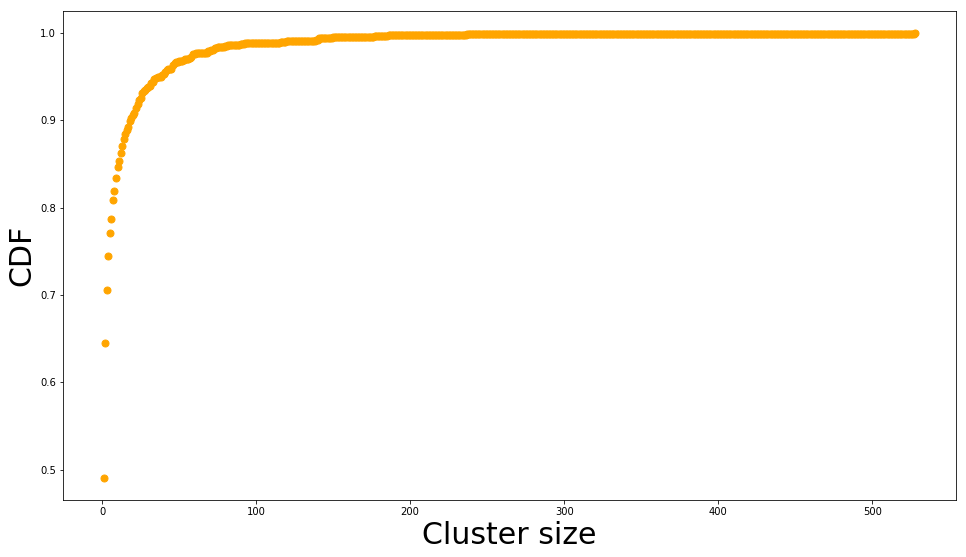

In [14]:
cdf_people = np.cumsum(pdf_people)
fig = plt.figure(figsize=(16,9))
assi = fig.gca()
assi.plot(bins_people[:-1],cdf_people,color='orange',marker='o',linestyle='None', ms = 7)#linestyle='--'
assi.set_xlabel('Cluster size',size=30)
assi.set_ylabel('CDF',size=30)
#fig.savefig('/Users/Cheick/Desktop/cdf_2k.png', dpi=300)

### Cluster_size_threshold

In [15]:
cluster_size_threshold = np.percentile(cl_lens,90)

In [16]:
x = [cl for cl in jd.clusters if len(cl.tweets) >= cluster_size_threshold]
y = [cl for cl in jd.clusters if len(cl.tweets) < cluster_size_threshold]
print len(x)
print len(y)

94
835


### Cluster vs rumors

Plot usando stacked bars

In [17]:
from collections import Counter
perc = {}
clusters_over_100 =  [(i,cl) for i,cl in enumerate(jd.clusters) if len(cl.tweets) >= cluster_size_threshold]
#print a[0]
for el in clusters_over_100:
    i = el[0]
    cl = el[1]
    c = Counter()
    for t in cl.tweets:
        c.update({t['rumor']:1})
    perc[i] = c

https://matplotlib.org/gallery/lines_bars_and_markers/bar_stacked.html

obama
michelle
airfrance
palin
cell


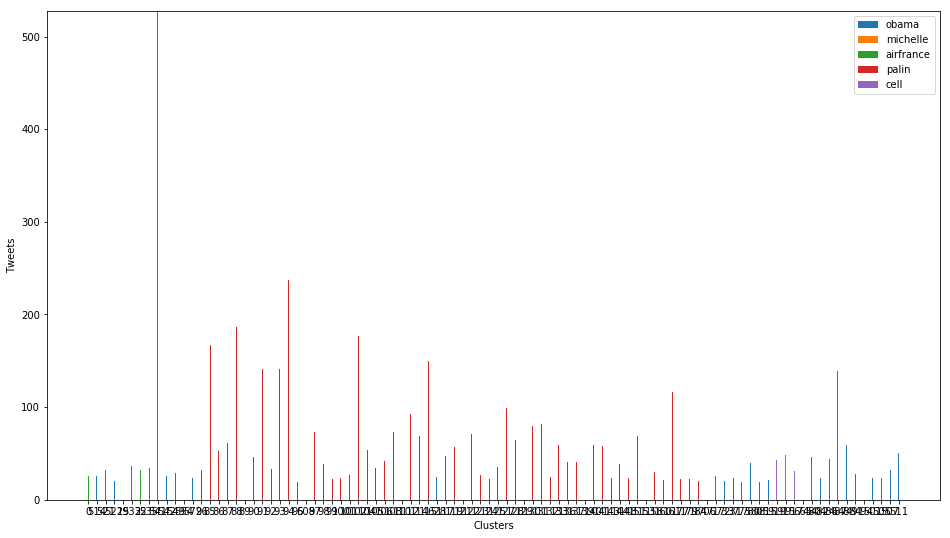

In [18]:
import numpy as np
import matplotlib.pyplot as plt

cluster_numbers = { }
rumors=['obama' , 'michelle' ,'airfrance','palin','cell']

previous = np.array(len(perc.keys()))
previous = [0 for x in perc.keys()]
#previous = [0,0,0,0,0,0,0]
plots = []
ind = np.arange(len(perc.keys()))
width = 0.1 #len(perc.keys()) # the width of the bars: can also be len(x) sequence

fig = plt.figure(figsize=(16,9)) #è la dimensione del grafico
assi = fig.gca()

for r in rumors:
    print r
    means = []
    for k in perc.keys():
        #print k
        #print r
        #print perc[k][r]
        means.append(perc[k][r])
        #print womenMeans
    #print womenMeans 
    p = assi.bar(ind, means, width, bottom=previous)
    previous = means
    plots.append((p,r))

plt.ylabel('Tweets')
#plt.title('Scores by group and gender')
plt.xticks(ind, perc.keys())
plt.xlabel('Clusters')
#plt.yticks(np.arange(0, 81, 10))
plt.legend([x[0] for x in plots], [x[1] for x in plots])
plt.show()

In [19]:
dates = {
    'obama':[],
    'michelle':[],
    'cell':[],
    'palin':[],
    'airfrance':[]
}
for tweet in [t  for cl in jd.clusters for t in cl.tweets]:
    dates[tweet['rumor']].append(tweet['date'].date()) 

In [20]:
from collections import Counter
c = Counter

c_dates= {
    'obama':[],
    'michelle':[],
    'cell':[],
    'palin':[],
    'airfrance':[]
}

from collections import OrderedDict
import datetime

for rumor in dates.keys():
    
    odct = OrderedDict()
    for item in dates[rumor]:
        try:
            odct[item] += 1
        except KeyError:
            odct[item] = 1
            
    c_dates[rumor] = odct

#print [(item, dates['cell'].count(item)) for item in list(OrderedDict.fromkeys(dates['cell']))]

In [21]:
import matplotlib.pyplot as plt
import matplotlib.dates
import numpy as np
%matplotlib inline

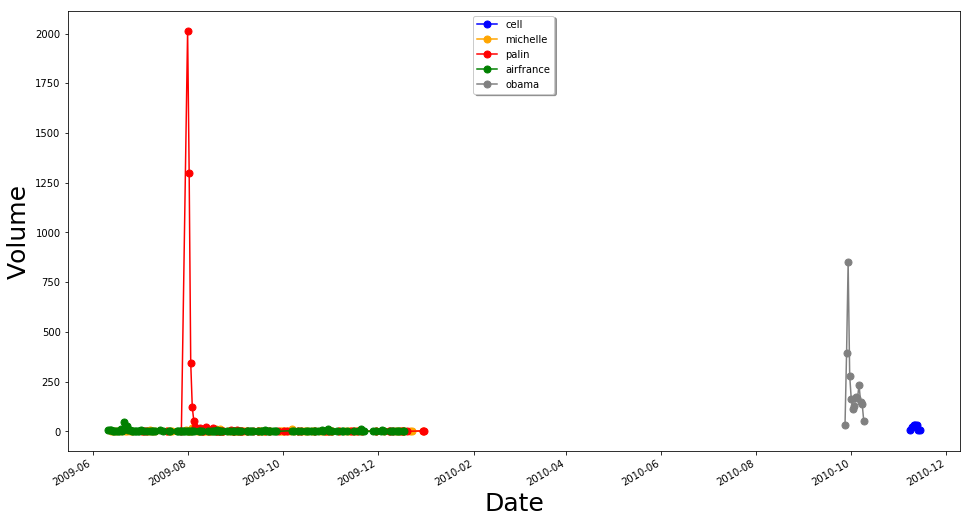

In [22]:
fig = plt.figure(figsize=(16,9)) #è la dimensione del grafico
assi = fig.gca()
colors = ['blue','orange','red','green','gray']
for i,rumor in enumerate(c_dates.keys()):
    assi.plot([d for d in c_dates[rumor].keys()],[v for v in c_dates[rumor].values() ],color=colors[i],marker='o',linestyle='-', ms = 7, label= rumor)

assi.set_xlabel('Date',size=25)
assi.set_ylabel('Volume',size=25)
legend = assi.legend(loc='upper center', shadow=True)
plt.gcf().autofmt_xdate()
#fig.savefig('/Users/Cheick/Desktop/pdf_2k.png', dpi=300)

### Visualizziamo per cluster

In [23]:
dates_cluster = {c.cluster_index:[] for c in jd.clusters}

for k in dates_cluster:
    for tweet in jd.clusters[k].tweets:
        dates_cluster[k].append(tweet['date'].date())
    

In [24]:
from collections import Counter
c = Counter

c_dates_cluster = {c.cluster_index:[] for c in jd.clusters}

from collections import OrderedDict
import datetime

for cl in c_dates_cluster.keys():
    #print cl
    odct = OrderedDict()
    for item in dates_cluster[cl]:
        try:
            odct[item] += 1
        except KeyError:
            odct[item] = 1
            
    c_dates_cluster[cl] = odct

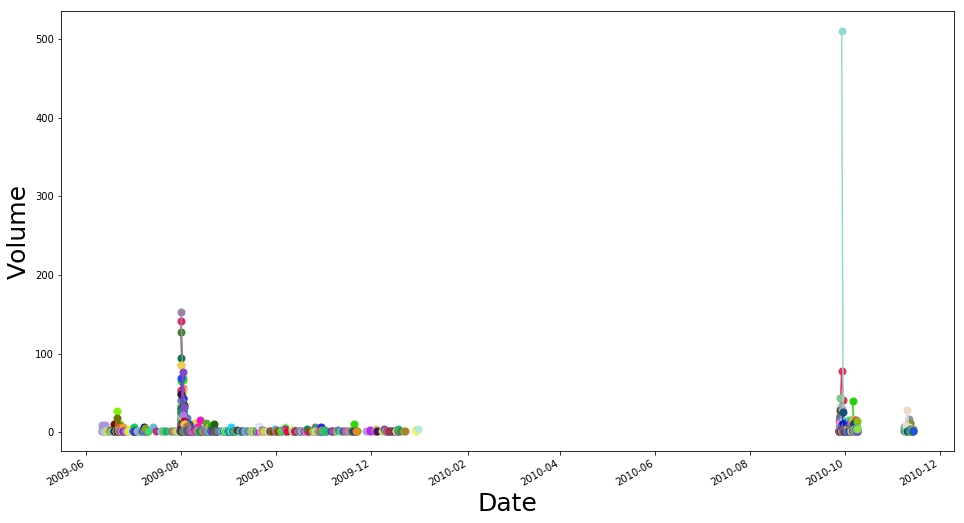

In [25]:
fig = plt.figure(figsize=(16,9)) #è la dimensione del grafico
assi = fig.gca()

colors = [np.random.rand(3,) for c in jd.clusters]

for i,cl in enumerate(c_dates_cluster.keys()):
    assi.plot([d for d in c_dates_cluster[cl].keys()],[v for v in c_dates_cluster[cl].values() ],color=colors[i],marker='o',linestyle='-', ms = 7)#, label= cl)

assi.set_xlabel('Date',size=25)
assi.set_ylabel('Volume',size=25)
#legend = assi.legend(loc='upper center', shadow=True)
plt.gcf().autofmt_xdate()
#fig.savefig('/Users/Cheick/Desktop/pdf_2k.png', dpi=300)

### Visualizziamo a livello temporale solo i clusteri più grandi

In [26]:
dates_cluster = {c.cluster_index:[] for c in jd.clusters if len(c.tweets)>cluster_size_threshold}

for k in dates_cluster:
    for tweet in jd.clusters[k].tweets:
        dates_cluster[k].append(tweet['date'].date())    

In [27]:
from collections import Counter
c = Counter

c_dates_cluster = {c.cluster_index:[] for c in jd.clusters if len(c.tweets)>cluster_size_threshold}

from collections import OrderedDict
import datetime

for cl in c_dates_cluster.keys():
    #print cl
    odct = OrderedDict()
    for item in dates_cluster[cl]:
        try:
            odct[item] += 1
        except KeyError:
            odct[item] = 1
            
    c_dates_cluster[cl] = odct

#print [(item, dates['cell'].count(item)) for item in list(OrderedDict.fromkeys(dates['cell']))]

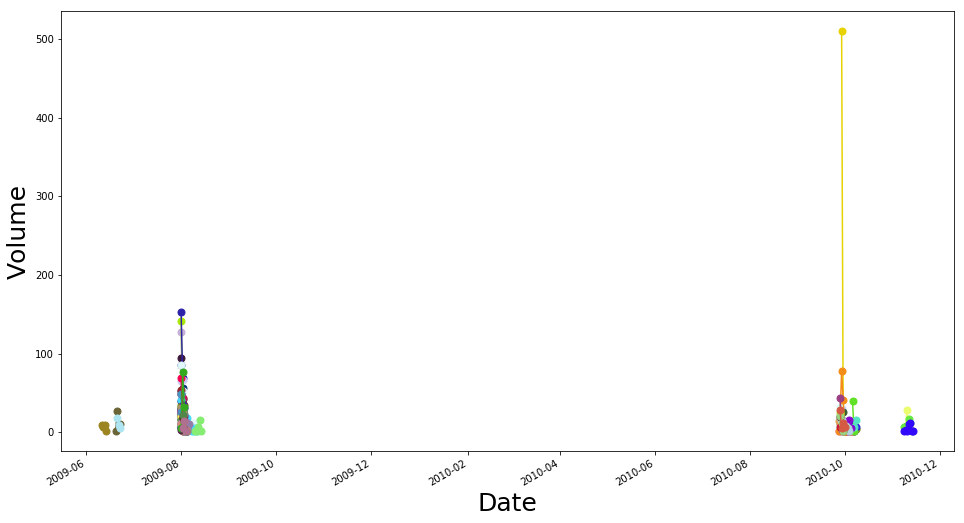

In [28]:
fig = plt.figure(figsize=(16,9)) #è la dimensione del grafico
assi = fig.gca()

colors = [np.random.rand(3,) for c in jd.clusters]

for i,cl in enumerate(c_dates_cluster.keys()):
    assi.plot([d for d in c_dates_cluster[cl].keys()],[v for v in c_dates_cluster[cl].values() ],color=colors[i],marker='o',linestyle='-', ms = 7)#, label= cl)

assi.set_xlabel('Date',size=25)
assi.set_ylabel('Volume',size=25)
#legend = assi.legend(loc='upper center', shadow=True)
plt.gcf().autofmt_xdate()
#fig.savefig('/Users/Cheick/Desktop/pdf_2k.png', dpi=300)

### Sim distribution

#### Nota
Bisogna tener conto del fatto che se un tweet viene analizzato quando non ci sono cluster attivi, ne inizia uno nuovo. Di default indichiamo con sim == 0.0 

In [29]:
cl_lens = [ t['sim'] for cl in jd.clusters for t in cl.tweets ]
print "len", len(cl_lens)
print np.mean(cl_lens)
print np.max(cl_lens)
print np.min(cl_lens)
print np.percentile(cl_lens,75)
print np.median(cl_lens)

len 7777
0.5896827951908845
1.0
0.0
0.8009965811024257
0.5916118380592673


In [30]:
import matplotlib.pyplot as plt
%matplotlib inline

Text(0,0.5,'Value')

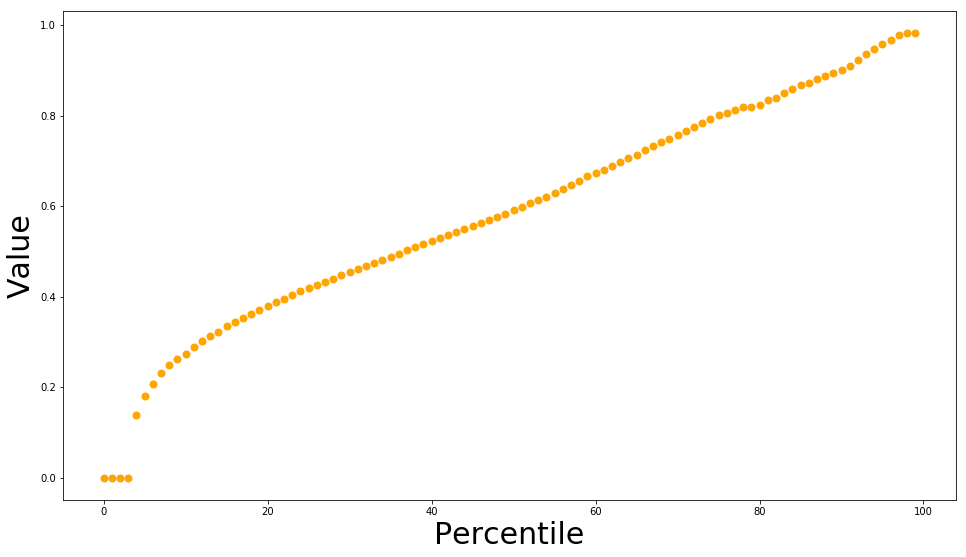

In [31]:
fig = plt.figure(figsize=(16,9)) #è la dimensione del grafico
assi = fig.gca()
assi.plot([i for i in range(100)],[np.percentile(cl_lens,i) for i in range(100)],color='orange',marker='o',linestyle='None', ms = 7)
assi.set_xlabel('Percentile',size=30)
assi.set_ylabel('Value',size=30)
#fig.savefig('/Users/Cheick/Desktop/pdf_2k.png', dpi=300)

In [32]:
x = [cl for cl in jd.clusters if len(cl.tweets) >= cluster_size_threshold]
y = [cl for cl in jd.clusters if len(cl.tweets) < cluster_size_threshold]
print len(x)
print len(y)

94
835


def get_labels(self, cluster_size_gte= 100):
        #gt: ground truth rumor di appartenenza
        gt_labels=[]
        pred_labels=[]
        gt_relev_labels = []

        for i, cl in enumerate(self.clusters):
            if len(cl.tweets)<cluster_size_gte :
                continue

            for t in cl.tweets:
                gt_labels.append(t['rumor'])
                pred_labels.append(i)
                if t['label'] in ['11','12','13','14']:
                     gt_relev_labels.append(1)
                else:
                    gt_relev_labels.append(int(t['label']))
        # es: t in cluster 0: (0, obama). Con purity cerco di capire se la mggioranza di label nel cluster 0 è obama o altro
        d = {}
        for i,e in enumerate(set(gt_labels)):
            d[e]=i
        gt_labels_numeric = [d[k] for k in gt_labels ]
        
        return gt_labels, pred_labels, gt_relev_labels, gt_labels_numeric

### Coverage
Coverage signifies what proportion of all tweets found
their way into our selectioned clusters which have more than cluster_size_threshold
tweets.

In [33]:
x = sum([len(cl.tweets) for cl in jd.clusters if len(cl.tweets) >= cluster_size_threshold])
print x
tot = sum([len(cl.tweets) for cl in jd.clusters])
print tot
try:
    print float(x)/tot
except:
    print "No cluster over zero"

5364
7777
0.689726115469


### Purity
Purity of the clusters measures how many tweets in a cluster,
should actually be in the same cluster.

Purity is a measure of the extent to which clusters contain a single class. Its calculation can be thought of as follows: For each cluster, count the number of data points from the most common class in said cluster. Now take the sum over all clusters and divide by the total number of data points. 

Note that this measure doesn't penalize having many clusters. So for example, a purity score of 1 is possible by putting each data point in its own cluster. Also purity doesn't work well for imbalanced data: if a size 1000 dataset consists of two classes, one class contains 999 points and the other has only 1 point. No matter how bad a clustering algorithm performs, it will always give a very high purity value.

https://stackoverflow.com/questions/44302824/compute-centroid-and-accuracy

In [34]:
def compute_cluster_purity(gt_labels, pred_labels):
    """
    Compute purity of predicted labels (pred_labels), given 
    the ground-truth labels (gt_labels).

    Assuming gt_labels and pred_labels are both lists of int of length n
    """
    n = len(gt_labels) # number of elements
    
    if n == 0:
        print "No labels in ground truth were given"
        return 0.0
    
    assert len(pred_labels) == n
    purity = 0
    for l in set(pred_labels):
    # for predicted label l, what are the gt_labels of this cluster?
        gt = [gt_labels[i] for i, il in enumerate(pred_labels) if il==l]
        # most frequent gt label in this cluster:
        mfgt = max(set(gt), key=gt.count)
        purity += gt.count(mfgt) # count intersection between most frequent ground truth and this cluster
    
    return float(purity)/n

In [35]:
gt_labels, pred_labels, gt_relev_labels, gt_labels_numeric = jd.get_labels(cluster_size_gte = cluster_size_threshold)

#### Purity della separazione dei rumors

In [36]:
compute_cluster_purity(gt_labels, pred_labels)

0.9958985831469053

#### Purity della separazione tra rilevanti e non rilevanti

In [37]:
compute_cluster_purity(gt_relev_labels, pred_labels)

0.947800149142431

### Rand Coefficient

https://stackoverflow.com/a/49586743

https://stats.stackexchange.com/questions/89030/rand-index-calculation

In [38]:
import numpy as np
from scipy.special import comb
def rand_index_score(clusters, classes):
    tp_plus_fp = comb(np.bincount(clusters), 2).sum()
    tp_plus_fn = comb(np.bincount(classes), 2).sum()
    A = np.c_[(clusters, classes)]
    tp = sum(comb(np.bincount(A[A[:, 0] == i, 1]), 2).sum()
             for i in set(clusters))
    fp = tp_plus_fp - tp
    fn = tp_plus_fn - tp
    tn = comb(len(A), 2) - tp - fp - fn
    return (tp + tn) / (tp + fp + fn + tn)

In [39]:
#As a simple example:
labels_true = [1, 1, 0, 0, 0, 0,2,2]
labels_pred = [0, 0, 0, 1, 0, 1,2,2]
rand_index_score (labels_true, labels_pred)
#0.46666666666666667

0.7142857142857143

d = {}
for i,e in enumerate(set(gt_labels)):
    #print i
    d[e]=i
print d
gt_labels_numeric = [d[k] for k in gt_labels ]
#print gt_labels_numeric
print len(gt_labels_numeric)

In [40]:
rand_index_score (gt_labels_numeric , pred_labels)

0.49541629662630254

In [41]:
rand_index_score (gt_relev_labels , pred_labels)

0.3461065913696228

### F Score
The F-score is a weighted average of
recall and precision. To calculate precision, we took into account
false positives, as the irrelevant tweets included in the cluster. To
calculate recall, we considered all the false negatives, as the relevant
tweets which were not included in the correct cluster. The
average F-score

In [42]:
import numpy as np
from scipy.special import comb
def get_tp_fp_fn_tn(clusters, classes):
    tp_plus_fp = comb(np.bincount(clusters), 2).sum()
    tp_plus_fn = comb(np.bincount(classes), 2).sum()
    A = np.c_[(clusters, classes)]
    tp = sum(comb(np.bincount(A[A[:, 0] == i, 1]), 2).sum()
             for i in set(clusters))
    fp = tp_plus_fp - tp
    fn = tp_plus_fn - tp
    tn = comb(len(A), 2) - tp - fp - fn
    return tp, fp , fn ,tn

In [43]:
tp,fp,fn,tn=get_tp_fp_fn_tn(gt_labels_numeric , pred_labels)

#### Prec recall cluster

In [44]:
rec = tp/(tp + fn)
prec = tp/(tp+fp)
print rec, prec

0.993855584487888 0.04510813610497344


In [45]:
fscore = 2 * (prec * rec )/( prec + rec ) 
#in alternativa sklearn.metrics.f1_score(y_true, y_pred); formula è cmq F1 = 2 * (precision * recall) / (precision + recall)
print fscore

0.08629940022965535


#### Prec recall relevance

In [46]:
tp,fp,fn,tn=get_tp_fp_fn_tn(gt_relev_labels , pred_labels)

In [47]:
rec = tp/(tp + fn)
prec = tp/(tp+fp)
print rec, prec

0.9657548149136186 0.03424189320690295


In [48]:
fscore = 2 * (prec * rec )/( prec + rec ) 
#in alternativa sklearn.metrics.f1_score(y_true, y_pred); formula è cmq F1 = 2 * (precision * recall) / (precision + recall)
print fscore

0.06613876419348948


## All measures

In [49]:
# calculate evaluation metrics
gt_labels, pred_labels, gt_relev_labels, gt_labels_numeric = jd.get_labels(cluster_size_gte = cluster_size_threshold)

## COVERAGE
print "Coverage: "+ str(jd.coverage(cluster_size_threshold=cluster_size_threshold))

## PURITY
print "Purity rumor", compute_cluster_purity(gt_labels, pred_labels)
print "Purity relev", compute_cluster_purity(gt_relev_labels, pred_labels)


#RAND
#print "Adjusted Rand index", str(metrics.adjusted_rand_score(gt_labels, pred_labels))

print "rand index rumor", rand_index_score (gt_labels_numeric , pred_labels)
print "rand index relev", rand_index_score (gt_relev_labels , pred_labels)


tp,fp,fn,tn = get_tp_fp_fn_tn(gt_labels_numeric , pred_labels)
## PREC, RECALL
rec = tp/(tp + fn)
prec = tp/(tp+fp)
print "recall", rec, "precision", prec
# F-SCORE
fscore = 2 * (prec * rec )/( prec + rec ) 
print "fscore",fscore

tp,fp,fn,tn = get_tp_fp_fn_tn(gt_relev_labels , pred_labels)
## PREC, RECALL
rec = tp/(tp + fn)
prec = tp/(tp+fp)
print "recall", rec, "precision", prec
# F-SCORE
fscore = 2 * (prec * rec )/( prec + rec ) 
print "fscore",fscore

Coverage: 0.689726115469
Purity rumor 0.995898583147
Purity relev 0.947800149142
rand index rumor 0.49541629662630254
rand index relev 0.3461065913696228
recall 0.993855584487888 precision 0.04510813610497344
fscore 0.08629940022965535
recall 0.9657548149136186 precision 0.03424189320690295
fscore 0.06613876419348948


In [68]:
# calculate evaluation metrics
cl_lens = [len(c.tweets) for c in jd.clusters]

for i in range(20,100,10):
    cluster_size_threshold = np.percentile(cl_lens,i)
    print "Percentile", i ,cluster_size_threshold
    print "# clusters", sum([1 for cl in jd.clusters if len(cl.tweets) >= cluster_size_threshold])
    
    gt_labels, pred_labels, gt_relev_labels, gt_labels_numeric = jd.get_labels(cluster_size_gte = cluster_size_threshold)

    ## COVERAGE
    coverage = jd.coverage(cluster_size_threshold=cluster_size_threshold)
    print "Coverage: ", coverage

    ## PURITY
    print "Purity rumor", compute_cluster_purity(gt_labels, pred_labels)
    print "Purity relev", compute_cluster_purity(gt_relev_labels, pred_labels)


    #RAND
    #print "Adjusted Rand index", str(metrics.adjusted_rand_score(gt_labels, pred_labels))

    print "rand index rumor", rand_index_score (gt_labels_numeric , pred_labels)
    print "rand index relev", rand_index_score (gt_relev_labels , pred_labels)


    tp,fp,fn,tn = get_tp_fp_fn_tn(gt_labels_numeric , pred_labels)
    ## PREC, RECALL
    print tp,fp,fn,tn
    rec = tp/(tp + fn)
    prec = tp/(tp+fp)
    print "recall", rec, "precision", prec
    # F-SCORE
    fscore = 2 * (prec * rec )/( prec + rec ) 
    print "fscore",fscore

    tp,fp,fn,tn = get_tp_fp_fn_tn(gt_relev_labels , pred_labels)
    ## PREC, RECALL
    rec = tp/(tp + fn)
    prec = tp/(tp+fp)
    print "recall", rec, "precision", prec
    # F-SCORE
    fscore = 2 * (prec * rec )/( prec + rec ) 
    print "fscore",fscore
    #print i,cluster_size_threshold,coverage,compute_cluster_purity(gt_labels, pred_labels), compute_cluster_purity(gt_relev_labels, pred_labels),rand_index_score (gt_labels_numeric , pred_labels), rand_index_score (gt_relev_labels , pred_labels)
    print len(gt_labels)
    print "----"
    

Percentile 20 1.0
# clusters 929
Coverage:  1.0
Purity rumor 0.996271055677
Purity relev 0.927349877845
rand index rumor 0.5970123798094095
rand index relev 0.45345159515951594
350052.0 12182991.0 2136.0 17701797.0
recall 0.9939350574125183 precision 0.02793032785413726
fscore 0.0543338338288231
recall 0.9612962395084443 precision 0.02009133401029037
fscore 0.0393600333893601
7777
----
Percentile 30 1.0
# clusters 929
Coverage:  1.0
Purity rumor 0.996271055677
Purity relev 0.927349877845
rand index rumor 0.5970123798094095
rand index relev 0.45345159515951594
350052.0 12182991.0 2136.0 17701797.0
recall 0.9939350574125183 precision 0.02793032785413726
fscore 0.0543338338288231
recall 0.9612962395084443 precision 0.02009133401029037
fscore 0.0393600333893601
7777
----
Percentile 40 1.0
# clusters 929
Coverage:  1.0
Purity rumor 0.996271055677
Purity relev 0.927349877845
rand index rumor 0.5970123798094095
rand index relev 0.45345159515951594
350052.0 12182991.0 2136.0 17701797.0
recall 